#Week 1
## Introduction

In this first hands-on project, you will learn how to embed a TensorFlow model in Android using TG Lite!

This project uses the follwoing development tools:


*   TensorFlow 2.x (latest)
*   TensorFlow Datasets (latest)
*   Matplotlib (latest)
*   Python 3.x (latest)
*   Android Studio (latest)



#Installing dependecies
First, we need to install TensorFlow 2.x (its latest version at the time you follow this tutorial) and the TensorFlow Datasets library, so we can download the dataset we will use to train our model.

Those steps are implemented below:

In [2]:
# Installing TensorFlow 2.x
!pip install tensorflow
!pip install --upgrade tensorflow-datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 4.0 MB/s 
  Attempting uninstall: tensorflow-datasets
    Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


#Setup input pipeline
Once we have our tools ready, we need to download the stanford_dogs dataset to train our model.

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete44OUSD/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete44OUSD/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


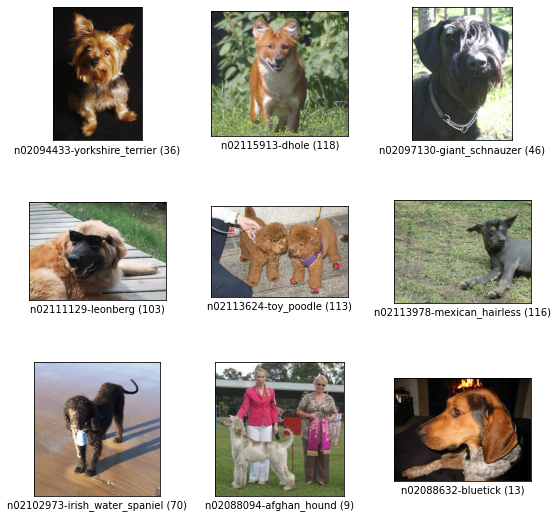

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# use tensorflow_datasets library to easily download the dataset StanfordDogs
dataset, ds_info = tfds.load("stanford_dogs", with_info=True)
training_data, test_data = dataset["train"], dataset["test"]

#plot some image samples from the training data
tfds.show_examples(training_data, ds_info)
plt.show()

#Preprocess the dataset
After we download the dataset, we need to convert their samples to the input format our model supports.

In [4]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

def preprocess(sample):
    """ Convert image from int to float, normalize it and resize it. """
    image, label = sample['image'], sample['label']
    image = tf.cast(image, tf.float32) / 255.
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return image, label

def prepare(dataset):
    ds = dataset.map(preprocess, num_parallel_calls=4)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

training_batches = prepare(training_data)
test_batches = prepare(test_data)

#Create the classification model
Now we can create the classification model using the MobileNetV2 nework developed by Google and pre-trained on ImageNet.

In [5]:
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


Once we have our base model, we freeze its layers and add an MLP top layer on its top, which will be fine-tuned during the model training.

In [7]:
base_model.trainable = False
NUM_CLASSES = ds_info.features['label'].num_classes
model = tf.keras.Sequential([
                             base_model,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dense(512, activation='elu'),
                             tf.keras.layers.Dense(256, activation='elu'),
                             tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

Finally, we can compile our whole model.

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#Train and test model
To train our model, we only need to rely on Keras' fit() method.

In [ ]:
# This callback will stop the training when there is no improvement in
# the validation accuracy for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

# train model
history = model.fit(training_batches,
                    epochs=30,
                    validation_data=test_batches,
                    callbacks=[callback])

# plot accuracy during training
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Test accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

Epoch 1/30
174/375 [============>.................] - ETA: 3:28 - loss: 3.1827 - accuracy: 0.3139

#Converting the model to TF Lite

In [ ]:
# Loard the TF Lite converter and get a converted model.
import tensorflow as tf
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#Testing the TF Lite model
Finally, we can run the converted TF Lite on the test dataset.

In [ ]:
import numpy as np

# Creating TF Lite interpreter
interpreter = tf.lite.Interpreter(model_content=tflite_model)

# Creating random input data
input_details = interpreter.get_input_details()
input_shape = input_details[0]['shape']
input_data = tf.convert_to_tensor(np.array(np.random.random_sample(input_shape), dtype=np.float32))

# Performing inference
interpreter.allocate_tensors()
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()

# Getting model's input
output_details = interpreter.get_output_details()
output = interpreter.get_tensor(output_details[0]['index'])
print("Input shape: ")
print(input_shape)
print("Model output shape: ")
print(output.shape)

#Saving the TF Lite Model
Finally, the last step is to export the TF Lite model as a .tflite file, so it can be embedded on the edge device for inference.

In [ ]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)